In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
#generates geometric brownian motion and the underlying bm
def gen_bs(t, n, x, r, sigma): #returns n+1 values - from 0 to n inclusive. Truncate if needed
    Z = np.random.normal(size=n)
    W = np.cumsum(np.sqrt(t)*np.append(np.array(0.0), Z)) #generate the underlying brownian motion
    V = np.append(np.array([1.0]), np.exp((r-0.5*sigma**2)*t+np.sqrt(t)*sigma*Z)) #generate the geometric BM process
    return (x*np.cumprod(V), W)

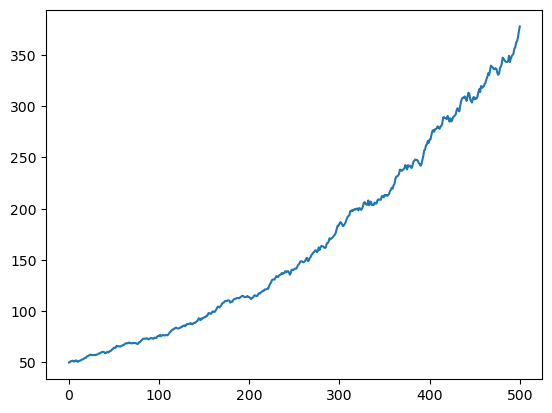

In [3]:
plt.plot(gen_bs(1/500, 500, 50, 2, 0.2)[0])

In [4]:
def g(x):
    return x if x>0 else 0

In [5]:
def method1(M, T, n, S0, K, r, sigma):
    h = T/n
    estimator = np.zeros(M)
    for i in range(M):
        bs = gen_bs(h, n, S0, r, sigma)[0][:-1] #generates n+1 values, we don't need the last
        S = h/T*bs.sum() #method 1 simply uses the Riemann sums as an approximation
        estimator[i] = (np.exp(-r*T)*g(S-K))
    rt = (estimator.mean(), (estimator.mean()-1.96*estimator.std(ddof=1)/np.sqrt(M),estimator.mean()+1.96*estimator.std(ddof=1)/np.sqrt(M)), estimator.std(ddof=1)/np.sqrt(M))
    print("Estimator:", np.round(rt[0], 3))
    print("Condidence Interval 95%:", np.round([rt[1][0],rt[1][1]], 3))
    print("Error:", 1.96*estimator.std(ddof=1)/np.sqrt(M), "%")
    return rt


In [6]:
%%time
#NOTE: the other values for n were also calculated with this seed
np.random.seed(31416) #reproduceability
method1(100000, 1, 1000, 100, 100, 0.1, 0.2)

Estimator: 7.074
Condidence Interval 95%: [7.021 7.127]
Error: 0.05305040717219933 %
CPU times: user 4.23 s, sys: 5.6 ms, total: 4.24 s
Wall time: 3.9 s


(7.074119125582671,
 (7.021068718410472, 7.12716953275487),
 0.027066534271530267)

In [7]:
def method2(M, T, n, S0, K, r, sigma):
    h = T/n
    estimator = np.zeros(M)
    for i in range(M):
        bsw = gen_bs(h, n, S0, r, sigma) #generates n+1 values
        bs, W = bsw[0][:-1], bsw[1] #we only need the first n values of the geometric BM, but we need n+1 values of the underlying BM
        S = h/T*(bs*(1+r*h/2+sigma*np.diff(W)/2)).sum() #method 2 uses consecutive differences of W
        estimator[i] = (np.exp(-r*T)*g(S-K))
    rt = (estimator.mean(), (estimator.mean()-1.96*estimator.std(ddof=1)/np.sqrt(M),estimator.mean()+1.96*estimator.std(ddof=1)/np.sqrt(M)), estimator.std(ddof=1)/np.sqrt(M))
    print("Estimator:", np.round(rt[0], 3))
    print("Condidence Interval 95%:", np.round([rt[1][0],rt[1][1]], 3))
    print("Error:", 1.96*estimator.std(ddof=1)/np.sqrt(M), "%")
    return rt

In [8]:
%%time
#NOTE: the other values for n were also calculated with this seed
np.random.seed(31416) #reproduceability
method2(100000, 1, 1000, 100, 100, 0.1, 0.2)

Estimator: 7.08
Condidence Interval 95%: [7.027 7.133]
Error: 0.053094862607878816 %
CPU times: user 4.32 s, sys: 2.47 ms, total: 4.32 s
Wall time: 4.35 s


(7.080368973472873, (7.027274110864994, 7.133463836080752), 0.0270892156162647)

In [9]:
def method3(M, T, n, S0, K, r, sigma):
    h = T/n
    estimator = np.zeros(M)
    for i in range(M):
        bsw = gen_bs(h, n, S0, r, sigma) #n+1 values
        bs, W = bsw[0][:-1], bsw[1] #again, only n vaslues of the GeoBM are needed, but n+1 of the underlying BM are needed
        int_rv = h*np.convolve(W, [0.5, 0.5], "valid")+np.sqrt(h**3/12)*np.random.normal(size=n) #efficient way to compute consecutive means, returns n valuesd
        int_rv = int_rv-h*W[:-1]
        S = 1/T*(bs*(h+r*h**2/2+sigma*int_rv)).sum()
        estimator[i] = (np.exp(-r*T)*g(S-K))
    rt = (estimator.mean(), (estimator.mean()-1.96*estimator.std(ddof=1)/np.sqrt(M),estimator.mean()+1.96*estimator.std(ddof=1)/np.sqrt(M)), estimator.std(ddof=1)/np.sqrt(M))
    print("Estimator:", np.round(rt[0], 3))
    print("Condidence Interval 95%:", np.round([rt[1][0],rt[1][1]], 3))
    print("Error:", 1.96*estimator.std(ddof=1)/np.sqrt(M), "%")
    return rt

In [10]:
%%time
#NOTE: the other values for n were also calculated with this seed
np.random.seed(31416) #reproduceability
method3(10000, 1, 1000, 100, 200, 1, 1)

Estimator: 12.748
Condidence Interval 95%: [12.032 13.463]
Error: 0.7155633636787218 %
CPU times: user 604 ms, sys: 827 µs, total: 605 ms
Wall time: 609 ms


(12.74792395109164,
 (12.032360587412917, 13.463487314770362),
 0.36508334881567434)

In [11]:
#Comparison between methods: n ranging from 5 to 100, increments of 5. 20000 montecarlo steps
meth1 = np.zeros(20)
meth2 = np.zeros(20)
meth3 = np.zeros(20)

In [12]:
np.random.seed(31416) #reproduceability
for i in range(20):
    meth1[i] = method1(20000, 1, 5*i+5, 100, 100, 0.1, 0.2)[0]
    meth2[i] = method2(20000, 1, 5*i+5, 100, 100, 0.1, 0.2)[0]
    meth3[i] = method3(20000, 1, 5*i+5, 100, 100, 0.1, 0.2)[0]
    print(i)


Estimator: 5.743
Condidence Interval 95%: [5.644 5.841]
Error: 0.09871925881988237 %
Estimator: 6.968
Condidence Interval 95%: [6.852 7.084]
Error: 0.1159095785334531 %
Estimator: 7.043
Condidence Interval 95%: [6.925 7.162]
Error: 0.11834757540979637 %
0
Estimator: 6.417
Condidence Interval 95%: [6.308 6.525]
Error: 0.10892330521881761 %
Estimator: 7.027
Condidence Interval 95%: [6.908 7.146]
Error: 0.11935181376683612 %
Estimator: 7.073
Condidence Interval 95%: [6.955 7.191]
Error: 0.11779718713251598 %
1
Estimator: 6.575
Condidence Interval 95%: [6.464 6.686]
Error: 0.11090792329860857 %
Estimator: 7.081
Condidence Interval 95%: [6.962 7.199]
Error: 0.11875199566645939 %
Estimator: 7.072
Condidence Interval 95%: [6.953 7.19 ]
Error: 0.11859369613584426 %
2
Estimator: 6.797
Condidence Interval 95%: [6.683 6.911]
Error: 0.11437302390226839 %
Estimator: 7.048
Condidence Interval 95%: [6.929 7.166]
Error: 0.11855222049842298 %
Estimator: 7.09
Condidence Interval 95%: [6.971 7.209]
Error

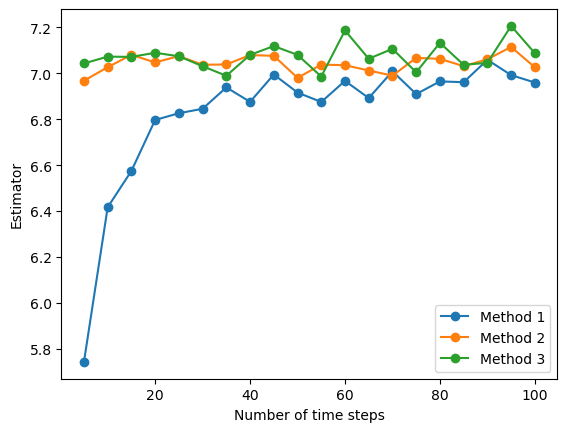

In [13]:
plt.plot(np.arange(5,105, 5), meth1, "-o", label='Method 1')
plt.plot(np.arange(5,105, 5), meth2, "-o", label='Method 2')
plt.plot(np.arange(5,105, 5), meth3, "-o", label='Method 3')
plt.xlabel("Number of time steps")
plt.ylabel("Estimator")
plt.legend()

# Variance reduction

In [14]:
from scipy.stats import norm
#computes the theoretical EV for Z, the control variable
def control_expectation(T, S0, K, r, sigma):
    d = (np.log(S0/K)+0.5*(r+1/6*sigma**2)*T)/(sigma*np.sqrt(T/3))
    dstar = 0.5*(r-1/6*sigma**2)*T
    return np.exp(-r*T)*(np.exp(dstar)*S0*norm.cdf(d)-K*norm.cdf(d-sigma*np.sqrt(T/3)))

In [15]:
def method1_control(M, T, n, S0, K, r, sigma):
    h = T/n
    Y, Z = np.zeros(M), np.zeros(M)
    for i in range(M):
        bsw = gen_bs(h, n, S0, r, sigma)
        bs, W = bsw[0][:-1], bsw[1]
        S = h/T*bs.sum()
        Y[i] = (np.exp(-r*T)*g(S-K))
        Z[i] = np.exp(-r*T)*g(S0*np.exp(0.5*T*(r-0.5*sigma**2)+sigma*h/T*W[:-1].sum())-K)
    cov_mat = np.cov([Y, Z])
    b = -cov_mat[0,1]/cov_mat[1,1]
    estimator = Y+b*(Z-control_expectation(T, S0, K, r, sigma))
    rt = (estimator.mean(), (estimator.mean()-1.96*estimator.std(ddof=1)/np.sqrt(M),estimator.mean()+1.96*estimator.std(ddof=1)/np.sqrt(M)), estimator.std(ddof=1)/np.sqrt(M))
    print("Estimator:", np.round(rt[0], 3))
    print("Condidence Interval 95%:", np.round([rt[1][0],rt[1][1]], 3))
    print("Error:", 1.96*estimator.std(ddof=1)/np.sqrt(M), "%")
    return rt

In [16]:
%%time
#NOTE: the other values for n were also calculated with this seed
np.random.seed(31416) #reproduceability
method1_control(100000, 1, 1000, 100, 100, 0.1, 0.2)

Estimator: 7.04
Condidence Interval 95%: [7.039 7.042]
Error: 0.0015761253101797188 %
CPU times: user 4.03 s, sys: 4.18 ms, total: 4.03 s
Wall time: 4.06 s


(7.04031822210249, (7.03874209679231, 7.04189434741267), 0.0008041455664182239)

In [17]:
def method2_control(M, T, n, S0, K, r, sigma):
    h = T/n
    Y, Z = np.zeros(M), np.zeros(M)
    for i in range(M):
        bsw = gen_bs(h, n, S0, r, sigma)
        bs, W = bsw[0][:-1], bsw[1]
        S = h/T*(bs*(1+r*h/2+sigma*np.diff(W)/2)).sum()
        Y[i] = (np.exp(-r*T)*g(S-K))
        Z[i] = np.exp(-r*T)*g(S0*np.exp(0.5*T*(r-0.5*sigma**2)+sigma*0.5*h/T*(2*W.sum()-W[0]-W[-1]))-K) #trick to compute sum of W_ti+W_Ti+1
    cov_mat = np.cov([Y, Z])
    b = -cov_mat[0,1]/cov_mat[1,1]
    estimator = Y+b*(Z-control_expectation(T, S0, K, r, sigma))
    rt = (estimator.mean(), (estimator.mean()-1.96*estimator.std(ddof=1)/np.sqrt(M),estimator.mean()+1.96*estimator.std(ddof=1)/np.sqrt(M)), estimator.std(ddof=1)/np.sqrt(M))
    print("Estimator:", np.round(rt[0], 3))
    print("Condidence Interval 95%:", np.round([rt[1][0],rt[1][1]], 3))
    print("Error:", 1.96*estimator.std(ddof=1)/np.sqrt(M), "%")
    return rt

In [18]:
%%time
#NOTE: the other values for n were also calculated with this seed
np.random.seed(31416) #reproduceability
method2_control(100000, 1, 1000, 100, 100, 0.1, 0.2)

Estimator: 7.043
Condidence Interval 95%: [7.041 7.044]
Error: 0.0015779523349428019 %
CPU times: user 4.59 s, sys: 5.08 ms, total: 4.6 s
Wall time: 4.68 s


(7.04277673103505,
 (7.041198778700108, 7.044354683369993),
 0.0008050777219095929)

In [19]:
def method3_control(M, T, n, S0, K, r, sigma):
    h = T/n
    Y, Z = np.zeros(M), np.zeros(M)
    for i in range(M):
        bsw = gen_bs(h, n, S0, r, sigma)
        bs, W = bsw[0][:-1], bsw[1]
        int_rv = h*np.convolve(W, [0.5, 0.5], "valid")+np.sqrt(h**3/12)*np.random.normal(size=n)
        Z[i] = np.exp(-r*T)*g(S0*np.exp(0.5*T*(r-0.5*sigma**2)+sigma/T*int_rv.sum())-K)
        int_rv = int_rv-h*W[:-1]
        S = 1/T*(bs*(h+r*h**2/2+sigma*int_rv)).sum()
        Y[i] = (np.exp(-r*T)*g(S-K))
    cov_mat = np.cov([Y, Z])
    b = -cov_mat[0,1]/cov_mat[1,1]
    estimator = Y+b*(Z-control_expectation(T, S0, K, r, sigma))
    rt = (estimator.mean(), (estimator.mean()-1.96*estimator.std(ddof=1)/np.sqrt(M),estimator.mean()+1.96*estimator.std(ddof=1)/np.sqrt(M)), estimator.std(ddof=1)/np.sqrt(M))
    print("Estimator:", np.round(rt[0], 3))
    print("Condidence Interval 95%:", np.round([rt[1][0],rt[1][1]], 3))
    print("Error:", 1.96*estimator.std(ddof=1)/np.sqrt(M), "%")
    return rt

In [20]:
%%time
#NOTE: the other values for n were also calculated with this seed
np.random.seed(31416) #reproduceability
method3_control(10000, 1, 1000, 1, 1, 0.02, 0.05)

Estimator: 0.017
Condidence Interval 95%: [0.017 0.017]
Error: 2.789023507273533e-06 %
CPU times: user 636 ms, sys: 1.37 ms, total: 637 ms
Wall time: 642 ms


(0.016971690231594953,
 (0.01696890120808768, 0.016974479255102225),
 1.4229711771803739e-06)

In [21]:
meth1_control = np.zeros(20)
meth2_control = np.zeros(20)
meth3_control = np.zeros(20)
error2_control = np.zeros(20)
error3_control = np.zeros(20)

In [22]:
np.random.seed(31416) #reproduceability
for i in range(20):
    meth1_control[i] = method1_control(20000, 1, 5*i+5, 100, 100, 0.1, 0.2)[0]
    m2 = method2_control(20000, 1, 5*i+5, 100, 100, 0.1, 0.2)
    meth2_control[i] = m2[0]
    error2_control[i] = m2[2]
    m3 = method3_control(20000, 1, 5*i+5, 100, 100, 0.1, 0.2)
    meth3_control[i] = m3[0]
    error3_control[i] = m3[2]
    print(i)


Estimator: 6.526
Condidence Interval 95%: [6.521 6.531]
Error: 0.005041638540112666 %
Estimator: 7.038
Condidence Interval 95%: [7.035 7.041]
Error: 0.002928662864168019 %
Estimator: 7.033
Condidence Interval 95%: [7.03  7.036]
Error: 0.003247578450414322 %
0
Estimator: 6.79
Condidence Interval 95%: [6.787 6.794]
Error: 0.0036864358891314426 %
Estimator: 7.043
Condidence Interval 95%: [7.04  7.046]
Error: 0.003338851666433937 %
Estimator: 7.038
Condidence Interval 95%: [7.035 7.042]
Error: 0.0033154591365019675 %
1
Estimator: 6.872
Condidence Interval 95%: [6.869 6.876]
Error: 0.0035214686664529495 %
Estimator: 7.042
Condidence Interval 95%: [7.039 7.046]
Error: 0.003419510063202278 %
Estimator: 7.04
Condidence Interval 95%: [7.036 7.043]
Error: 0.003439028981824042 %
2
Estimator: 6.918
Condidence Interval 95%: [6.915 6.922]
Error: 0.0035699361422596378 %
Estimator: 7.04
Condidence Interval 95%: [7.036 7.043]
Error: 0.0034026525050080375 %
Estimator: 7.04
Condidence Interval 95%: [7.03

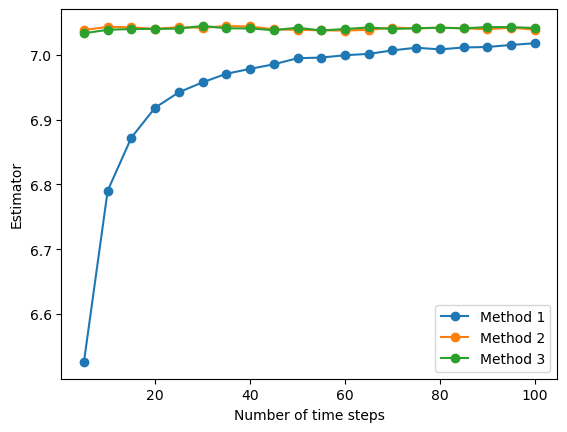

In [23]:
plt.plot(np.arange(5,105, 5), meth1_control, "-o", label='Method 1')
plt.plot(np.arange(5,105, 5), meth2_control, "-o", label='Method 2')
plt.plot(np.arange(5,105, 5), meth3_control, "-o", label='Method 3')
plt.xlabel("Number of time steps")
plt.ylabel("Estimator")
plt.legend()

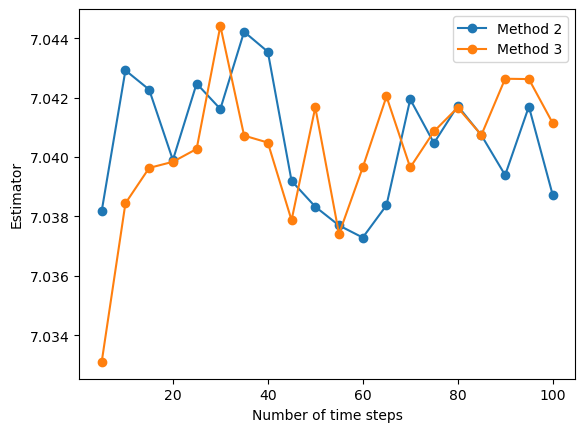

In [24]:
plt.plot(np.arange(5,105, 5), meth2_control, "-o", label='Method 2')
plt.plot(np.arange(5,105, 5), meth3_control, "-o", label='Method 3')
plt.xlabel("Number of time steps")
plt.ylabel("Estimator")
plt.legend()

# PDE approach

In [25]:
import numpy as np
import scipy.optimize as so
import scipy.stats as sps  #library for probability functions
import matplotlib.pyplot as plt #library for plots
from time import time

def mesh_implicit():
      delta=0.005
      h=0.00005
      m=int(T/h)
      l=int((beta - alpha)/delta - 1 )

      x=np.linspace(alpha, beta, l+2)
      t=np.linspace(0,T,m+1)
      return delta, h, m, l, x, t

def mesh():
      l=150
      m=160
      h=T/m
      delta=(beta-alpha)/(l+1)

      x=np.linspace(alpha, beta, l+2)
      t=np.linspace(0,T,m+1)

      return delta, h, m, l, x, t


def implicit_method(m, h, M, u, F):
      for i in range(m,0,-1):
            u[i-1,1:-1]=np.dot(np.linalg.inv(M), u[i,1:-1] + h * F[i,:])

def explicit_method(m, h, M, u, F):
      for i in range(m,0,-1):      
            u[i-1,1:-1]=np.dot(M, u[i,1:-1]) + dt * F[i,:] 


t1=time()

alpha, beta, sigma, r, T= 0, 3, 0.05, 0.1, 1
K=100
S0=100


delta, h, m, l, x, t=mesh()

u=np.zeros((m+1,l+2)) #since the mesh is 0<=i<=m ; 0<=k<= l+1


#boundary 
u[m,:]=0 #time terminal condition: since x^- is 0 if we consider x>= 0 
u[:,0]=(1-np.exp(-r*(T-t)))/r #space condition 
u[:,l+1]=0 #space condition 

Sigma=sigma*x
B=-(1/T + r*x)

sup=((Sigma[1:-2])**2 + 10**(-60))/(2*delta**2) + B[1:-2]/(2*delta)
sub=((Sigma[2:-1])**2 + 10**(-60))/(2*delta**2) - B[2:-1]/(2*delta)
dia=-(Sigma[1:-1]**2 + 10**(-60))/delta**2


Ad=np.diag(dia)
Asup=np.diag(sup,k=1)
Asub=np.diag(sub,k=-1)

A = Ad + Asup+ Asub

M=(np.diag(np.ones(l)) - h*A)

F=np.zeros((m+1,l))
F[:,0]=u[:,0]*(((Sigma[1])**2 + 10**(-60))/(2*delta**2) - B[1]/(2*delta))

explicit_method(m, h, M, u, F)

plt.plot(x,S0*u[0,:])

t2=time()

print(t2-t1, "seconds" )